# Name - Anurag Chowdhury
# Reg No. - 2148006
# Multivariate Analysis


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from scipy import stats


In [7]:
data = pd.read_csv("/content/sample_data/county_facts.csv")
primary_results = pd.read_csv("/content/sample_data/primary_results.csv")

In [8]:
data.loc[:, "PST045214":"POP060210"].describe()

,PST045214,PST040210,PST120214,POP010210,AGE135214,AGE295214,AGE775214,SEX255214,RHI125214,RHI225214,RHI325214,RHI425214,RHI525214,RHI625214,RHI725214,RHI825214,POP715213,POP645213,POP815213,EDU635213,EDU685213,VET605213,LFE305213,HSG010214,HSG445213,HSG096213,HSG495213,HSD410213,HSD310213,INC910213,INC110213,PVY020213,BZA010213,BZA110213,BZA115213,NES010213,SBO001207,SBO315207,SBO115207,SBO215207,SBO515207,SBO415207,SBO015207,MAN450207,WTN220207,RTN130207,RTN131207,AFN120207,BPS030214,LND110210,POP060210
count,3.195000e+03,3.195000e+03,3195.000000,3.195000e+03,3195.000000,3195.000000,3195.000000,3195.000000,3195.000000,3195.000000,3195.000000,3195.000000,3195.000000,3195.000000,3195.000000,3195.000000,3195.000000,3195.000000,3195.000000,3195.000000,3195.000000,3.195000e+03,3195.000000,3.195000e+03,3195.000000,3195.000000,3195.000000,3.195000e+03,3195.000000,3195.000000,3195.000000,3195.000000,3.195000e+03,3.195000e+03,3195.000000,3.195000e+03,3.195000e+03,3195.000000,3195.000000,3195.000000,3195.000000,3195.000000,3195.000000,3.195000e+03,3.195000e+03,3.195000e+03,3195.000000,3.195000e+03,3.195000e+03,3.195000e+03,3195.000000
mean,2.993963e+05,2.899137e+05,0.508545,2.899019e+05,5.900782,22.545290,17.524632,49.913271,84.953271,9.266479,2.243818,1.447230,0.126322,1.924820,9.044069,76.937308,86.362817,4.595806,9.343318,84.602723,19.906228,1.996599e+04,22.988638,1.257814e+05,72.058529,12.592081,131963.693271,1.085542e+05,2.526870,23697.013772,46060.551174,16.647731,7.025741e+03,1.100748e+05,0.689139,2.160151e+04,2.564908e+04,2.447230,0.598654,0.854742,0.019781,1.735055,18.108169,4.732329e+06,3.804132e+06,3.677504e+06,10287.325196,5.739886e+05,9.823005e+02,3.316344e+03,261.265227
std,5.768468e+06,5.584181e+06,4.180066,5.583955e+06,1.211925,3.418896,4.433712,2.425066,16.290780,14.382794,7.545606,2.818165,0.962070,1.544192,13.432315,19.906817,4.381599,5.646595,11.519709,6.877541,8.856957,3.831258e+05,5.459006,2.418522e+06,8.041995,9.415662,78208.400908,2.087882e+06,0.249673,5610.504751,11913.802788,6.461703,1.354179e+05,2.138890e+06,5.870719,4.174352e+05,4.909522e+05,6.886342,3.788530,2.692473,0.384601,6.222794,12.809596,9.623516e+07,7.613666e+07,7.082882e+07,5409.442797,1.112830e+07,1.902455e+04,6.402903e+04,1718.802670
min,0.000000e+00,0.000000e+00,-17.000000,8.200000e+01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,50.800000,0.000000,0.000000,45.000000,3.200000,2.000000e+00,4.400000,0.000000e+00,0.000000,0.000000,0.000000,3.300000e+01,1.390000,8768.000000,19986.000000,0.900000,0.000000e+00,0.000000e+00,-71.500000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,2.000000e+00,0.000000
25%,1.113450e+04,1.129500e+04,-1.900000,1.129500e+04,5.200000,20.500000,14.700000,49.500000,80.000000,0.800000,0.300000,0.400000,0.000000,1.200000,2.100000,65.200000,84.000000,1.300000,2.900000,80.300000,13.700000,9.035000e+02,19.200000,5.512000e+03,68.000000,6.300000,83900.000000,4.321500e+03,2.370000,19969.000000,38352.500000,12.100000,2.260000e+02,2.180000e+03,-1.700000,7.475000e+02,9.175000e+02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,7.818500e+04,6910.000000,6.240000e+03,6.000000e+00,4.325450e+02,17.150000
50%,2.655300e+04,2.644600e+04,-0.100000,2.642400e+04,5.800000,22.500000,17.200000,50.400000,91.900000,2.400000,0.600000,0.700000,0.100000,1.600000,3.900000,84.200000,86.800000,2.600000,5.100000,86.000000,17.700000,2.075000e+03,22.800000,1.273100e+04,73.200000,10.000000,109800.000000,1.005000e+04,2.500000,23021.000000,44301.000000,15.900000,5.550000e+02,6.578000e+03,0.700000,1.688000e+03,2.214000e+03,0.000000,0.000000,0.000000,0.000000,0.000000,23.400000,7.103000e+04,4.852600e+04,2.604220e+05,9806.000000,2.606300e+04,3.400000e+01,6.232800e+02,45.700000
75%,7.247600e+04,7.150450e+04,2.300000,7.144800e+04,6.500000,24.200000,19.800000,51.100000,

In [9]:
from IPython.display import display, HTML

# figures inline in notebook
%matplotlib inline

np.set_printoptions(suppress=False)

DISPLAY_MAX_ROWS = 20  # number of max rows to print for a DataFrame
pd.set_option('display.max_rows', DISPLAY_MAX_ROWS)

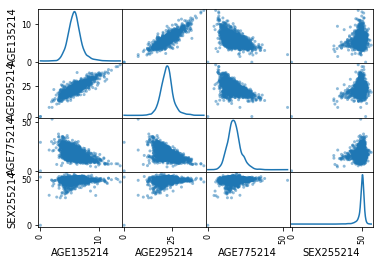

In [11]:
pd.plotting.scatter_matrix(data.loc[:, "AGE135214":"SEX255214"], diagonal="kde")
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y, data. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


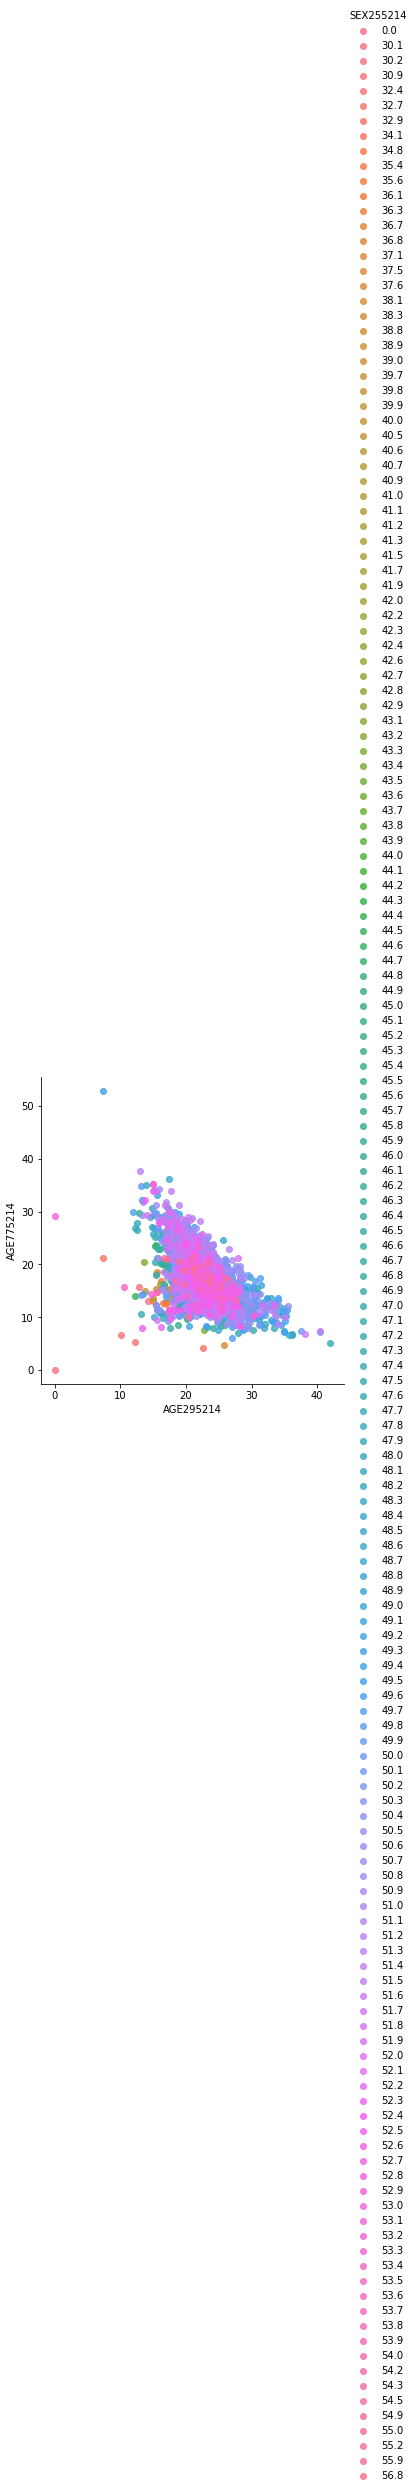

In [12]:
sns.lmplot("AGE295214", "AGE775214", data, hue="SEX255214", fit_reg=False);

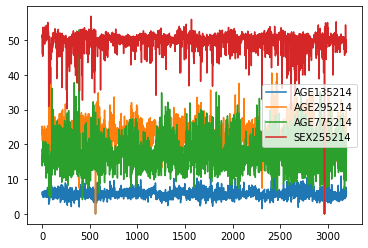

In [13]:
ax = data.loc[:, "AGE135214":"SEX255214"].plot()
ax.legend(loc='center right', bbox_to_anchor=(1, 0.5));

In [14]:
y = primary_results.candidate

Trump = primary_results[y=='Donald Trump']
Hillary = primary_results[y=='Hillary Clinton']
Bernie = primary_results[y=='Bernie Sanders']
Trump = Trump.query('fraction_votes > 0')
Hillary = Hillary.query('fraction_votes > 0')
Bernie = Bernie.query('fraction_votes > 0')

In [15]:
data = data.replace(to_replace='County', value="",regex=True)

In [16]:
Trump.columns = ['state','state_abbreviation', 'area_name','fips','party','candidate','votes','fraction_votes']
Hillary.columns = ['state','state_abbreviation', 'area_name','fips','party','candidate','votes','fraction_votes']
Bernie.columns = ['state','state_abbreviation', 'area_name','fips','party','candidate','votes','fraction_votes']

In [17]:
Trump.result = pd.merge(data, Trump, on='area_name')
Hillary.result = pd.merge(data, Hillary, on='area_name')
Bernie.result = pd.merge(data, Bernie, on='area_name')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  This is separate from the ipykernel package so we can avoid doing imports until


In [18]:
result = pd.concat([Trump.result, Hillary.result, Bernie.result], ignore_index=True)

In [19]:
y = result.candidate

In [20]:
X = result.loc[:, "PST045214":"POP060210"]

In [21]:
def printMeanAndSdByGroup(variables, groupvariable):
    data_groupby = variables.groupby(groupvariable)
    print("## Means:")
    display(data_groupby.apply(np.mean))
    print("\n## Standard deviations:")
    display(data_groupby.apply(np.std))
    print("\n## Sample sizes:")
    display(pd.DataFrame(data_groupby.apply(len)))

In [22]:
printMeanAndSdByGroup(X, y)

## Means:


,PST045214,PST040210,PST120214,POP010210,AGE135214,AGE295214,AGE775214,SEX255214,RHI125214,RHI225214,RHI325214,RHI425214,RHI525214,RHI625214,RHI725214,RHI825214,POP715213,POP645213,POP815213,EDU635213,EDU685213,VET605213,LFE305213,HSG010214,HSG445213,HSG096213,HSG495213,HSD410213,HSD310213,INC910213,INC110213,PVY020213,BZA010213,BZA110213,BZA115213,NES010213,SBO001207,SBO315207,SBO115207,SBO215207,SBO515207,SBO415207,SBO015207,MAN450207,WTN220207,RTN130207,RTN131207,AFN120207,BPS030214,LND110210,POP060210
candidate,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Bernie Sanders,6.382734e+06,6.097231e+06,4.238333,6.097058e+06,6.32000,23.030000,14.525000,50.27000,79.215000,8.625000,1.616667,6.193333,0.615000,3.803333,12.436667,68.558333,83.178333,10.881667,16.286667,88.681667,28.971667,489817.900000,24.268333,2.682104e+06,65.270000,23.313333,221928.333333,2.336903e+06,2.577000,28771.916667,56153.833333,14.083333,152523.600000,2.273629e+06,2.753333,415194.566667,514108.750000,2.955000,0.955000,5.670000,0.290000,3.928333,27.781667,1.120134e+08,7.379675e+07,8.112028e+07,14290.233333,1.194302e+07,28946.233333,65379.441333,144.481667
Donald Trump,6.359328e+06,6.075599e+06,4.212069,6.075421e+06,6.32069,23.041379,14.539655,50.27931,79.163793,8.781034,1.606897,6.124138,0.612069,3.779310,12.444828,68.494828,83.194828,10.801724,16.210345,88.636207,28.870690,486630.068966,24.218966,2.672413e+06,65.341379,23.234483,220543.103448,2.326826e+06,2.578276,28703.982759,56039.206897,14.106897,151685.965517,2.267750e+06,2.727586,415254.862069,512824.913793,3.056897,0.946552,5.631034,0.293103,3.953448,27.750000,1.120121e+08,7.369350e+07,8.071172e+07,14287.137931,1.192762e+07,28775.482759,65342.335172,145.974138
Hillary Clinton,6.382734e+06,6.097231e+06,4.238333,6.097058e+06,6.32000,23.030000,14.525000,50.27000,79.215000,8.625000,1.616667,6.193333,0.615000,3.803333,12.436667,68.558333,83.178333,10.881667,16.286667,88.681667,28.971667,489817.900000,24.268333,2.682104e+06,65.270000,23.313333,221928.333333,2.336903e+06,2.577000,28771.916667,56153.833333,14.083333,152523.600000,2.273629e+06,2.753333,415194.566667,514108.750000,2.955000,0.955000,5.670000,0.290000,3.928333,27.781667,1.120134e+08,7.379675e+07,8.112028e+07,14290.233333,1.194302e+07,28946.233333,65379.441333,144.481667



## Standard deviations:


,PST045214,PST040210,PST120214,POP010210,AGE135214,AGE295214,AGE775214,SEX255214,RHI125214,RHI225214,RHI325214,RHI425214,RHI525214,RHI625214,RHI725214,RHI825214,POP715213,POP645213,POP815213,EDU635213,EDU685213,VET605213,LFE305213,HSG010214,HSG445213,HSG096213,HSG495213,HSD410213,HSD310213,INC910213,INC110213,PVY020213,BZA010213,BZA110213,BZA115213,NES010213,SBO001207,SBO315207,SBO115207,SBO215207,SBO515207,SBO415207,SBO015207,MAN450207,WTN220207,RTN130207,RTN131207,AFN120207,BPS030214,LND110210,POP060210
candidate,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Bernie Sanders,5.144650e+06,4.844391e+06,1.68514,4.844192e+06,0.424185,1.435769,1.467722,0.687580,9.756772,8.662113,1.176601,4.976105,1.255763,2.780945,6.900603,10.753919,1.815865,4.433941,6.702946,2.674914,3.929508,340551.860046,2.381980,2.092869e+06,4.056530,4.608487,67566.784472,1.772493e+06,0.115330,2738.133843,5812.790369,2.363625,111313.610691,1.857782e+06,1.814797,401332.651709,431688.087622,4.788369,0.818622,5.864961,1.202733,4.198337,1.759403,1.094611e+08,7.681942e+07,6.137999e+07,1431.571507,8.995046e+06,29603.52143,45128.408527,128.305253
Donald Trump,5.231028e+06,4.925782e+06,1.70790,4.925579e+06,0.431421,1.458983,1.490654,0.697473,9.919603,8.768644,1.195518,5.046963,1.277130,2.825424,7.018428,10.932227,1.844696,4.488433,6.804707,2.709224,3.958231,345933.315748,2.407564,2.127985e+06,4.107312,4.667332,68301.739545,1.801950e+06,0.117093,2759.974041,5878.730906,2.400565,113123.548316,1.889267e+06,1.840427,408193.402306,439011.593007,4.838143,0.831330,5.961405,1.223176,4.267892,1.781055,1.113323e+08,7.813062e+07,6.238917e+07,1455.945876,9.148430e+06,30095.07287,45899.440238,130.242378
Hillary Clinton,5.144650e+06,4.844391e+06,1.68514,4.844192e+06,0.424185,1.435769,1.467722,0.687580,9.756772,8.662113,1.176601,4.976105,1.255763,2.780945,6.900603,10.753919,1.815865,4.433941,6.702946,2.674914,3.929508,340551.860046,2.381980,2.092869e+06,4.056530,4.608487,67566.784472,1.772493e+06,0.115330,2738.133843,5812.790369,2.363625,111313.610691,1.857782e+06,1.814797,401332.651709,431688.087622,4.788369,0.818622,5.864961,1.202733,4.198337,1.759403,1.094611e+08,7.681942e+07,6.137999e+07,1431.571507,8.995046e+06,29603.52143,45128.408527,128.305253



## Sample sizes:


,0
candidate,
Bernie Sanders,60
Donald Trump,58
Hillary Clinton,60


In [23]:
def calcWithinGroupsVariance(variable, groupvariable):
    # find out how many values the group variable can take
    levels = sorted(set(groupvariable))
    numlevels = len(levels)
    # get the mean and standard deviation for each group:
    numtotal = 0
    denomtotal = 0
    for leveli in levels:
        levelidata = variable[groupvariable==leveli]
        levelilength = len(levelidata)
        # get the standard deviation for group i:
        sdi = np.std(levelidata)
        numi = (levelilength)*sdi**2
        denomi = levelilength
        numtotal = numtotal + numi
        denomtotal = denomtotal + denomi
    # calculate the within-groups variance
    Vw = numtotal / (denomtotal - numlevels)
    return Vw

In [24]:
mapping = {'Donald Trump': 1, 'Hillary Clinton': 2, 'Bernie Sanders': 3}
result = result.replace({'candidate': mapping})

In [25]:
calcWithinGroupsVariance(result['candidate'], y)

0.0

In [26]:
def calcBetweenGroupsVariance(variable, groupvariable):
    # find out how many values the group variable can take
    levels = sorted(set((groupvariable)))
    numlevels = len(levels)
    # calculate the overall grand mean:
    grandmean = np.mean(variable)
    # get the mean and standard deviation for each group:
    numtotal = 0
    denomtotal = 0
    for leveli in levels:
        levelidata = variable[groupvariable==leveli]
        levelilength = len(levelidata)
        # get the mean and standard deviation for group i:
        meani = np.mean(levelidata)
        sdi = np.std(levelidata)
        numi = levelilength * ((meani - grandmean)**2)
        denomi = levelilength
        numtotal = numtotal + numi
        denomtotal = denomtotal + denomi
    # calculate the between-groups variance
    Vb = numtotal / (numlevels - 1)
    return(Vb)


In [27]:
calcBetweenGroupsVariance(result['candidate'], y)

58.98876404494382

In [28]:
def calcWithinGroupsCovariance(variable1, variable2, groupvariable):
    levels = sorted(set(groupvariable))
    numlevels = len(levels)
    Covw = 0.0
    # get the covariance of variable 1 and variable 2 for each group:
    for leveli in levels:
        levelidata1 = variable1[groupvariable==leveli]
        levelidata2 = variable2[groupvariable==leveli]
        mean1 = np.mean(levelidata1)
        mean2 = np.mean(levelidata2)
        levelilength = len(levelidata1)
        # get the covariance for this group:
        term1 = 0.0
        for levelidata1j, levelidata2j in zip(levelidata1, levelidata2):
            term1 += (levelidata1j - mean1)*(levelidata2j - mean2)
        Cov_groupi = term1 # covariance for this group
        Covw += Cov_groupi
    totallength = len(variable1)
    Covw /= totallength - numlevels
    return Covw

In [29]:
corrmat = X.corr()

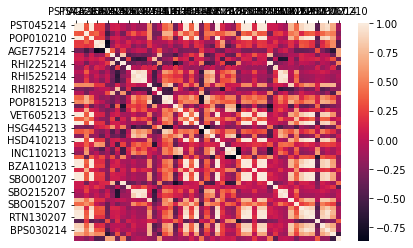

In [30]:
sns.heatmap(corrmat, vmax=1., square=False).xaxis.tick_top()

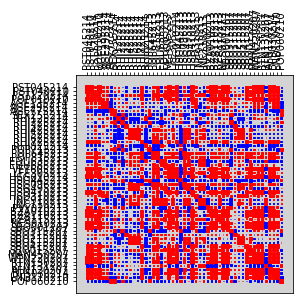

In [32]:

def hinton(matrix, max_weight=None, ax=None):
    """Draw Hinton diagram for visualizing a weight matrix."""
    ax = ax if ax is not None else plt.gca()

    if not max_weight:
        max_weight = 2**np.ceil(np.log(np.abs(matrix).max())/np.log(2))

    ax.patch.set_facecolor('lightgray')
    ax.set_aspect('equal', 'box')
    ax.xaxis.set_major_locator(plt.NullLocator())
    ax.yaxis.set_major_locator(plt.NullLocator())

    for (x, y), w in np.ndenumerate(matrix):
        color = 'red' if w > 0 else 'blue'
        size = np.sqrt(np.abs(w))
        rect = plt.Rectangle([x - size / 2, y - size / 2], size, size,
                             facecolor=color, edgecolor=color)
        ax.add_patch(rect)

    nticks = matrix.shape[0]
    ax.xaxis.tick_top()
    ax.set_xticks(range(nticks))
    ax.set_xticklabels(list(matrix.columns), rotation=90)
    ax.set_yticks(range(nticks))
    ax.set_yticklabels(matrix.columns)
    ax.grid(False)

    ax.autoscale_view()
    ax.invert_yaxis()

hinton(corrmat)

In [33]:
def mosthighlycorrelated(mydataframe, numtoreport):
    # find the correlations
    cormatrix = mydataframe.corr()
    # set the correlations on the diagonal or lower triangle to zero,
    # so they will not be reported as the highest ones:
    cormatrix *= np.tri(*cormatrix.values.shape, k=-1).T
    # find the top n correlations
    cormatrix = cormatrix.stack()
    cormatrix = cormatrix.reindex(cormatrix.abs().sort_values(ascending=False).index).reset_index()
    # assign human-friendly names
    cormatrix.columns = ["FirstVariable", "SecondVariable", "Correlation"]
    return cormatrix.head(numtoreport)

In [34]:
mosthighlycorrelated(X, 10)

,FirstVariable,SecondVariable,Correlation
0,PST040210,POP010210,1.000000
1,PST045214,POP010210,0.999573
2,PST045214,PST040210,0.999573
3,PST040210,BZA110213,0.998379
4,POP010210,BZA110213,0.998378
5,HSG010214,HSD410213,0.998229
6,POP010210,HSD410213,0.997640
7,PST040210,HSD410213,0.997640
8,PST045214,BZA110213,0.997540
9,BZA010213,RTN130207,0.997131


In [35]:
standardisedX = scale(X)
standardisedX = pd.DataFrame(standardisedX, index=X.index, columns=X.columns)

In [36]:
pca = PCA().fit(standardisedX)

In [37]:
def pca_summary(pca, standardised_data, out=True):
    names = ["PC"+str(i) for i in range(1, len(pca.explained_variance_ratio_)+1)]
    a = list(np.std(pca.transform(standardised_data), axis=0))
    b = list(pca.explained_variance_ratio_)
    c = [np.sum(pca.explained_variance_ratio_[:i]) for i in range(1, len(pca.explained_variance_ratio_)+1)]
    columns = pd.MultiIndex.from_tuples([("sdev", "Standard deviation"), ("varprop", "Proportion of Variance"), ("cumprop", "Cumulative Proportion")])
    summary = pd.DataFrame(list(zip(a, b, c)), index=names, columns=columns)
    if out:
        print("Importance of components:")
        display(summary)
    return summary


In [38]:
summary = pca_summary(pca, standardisedX)

Importance of components:


,sdev,varprop,cumprop
,Standard deviation,Proportion of Variance,Cumulative Proportion
PC1,4.277703e+00,3.587988e-01,0.358799
PC2,3.297137e+00,2.131591e-01,0.571958
PC3,2.471038e+00,1.197261e-01,0.691684
PC4,2.116121e+00,8.780329e-02,0.779487
PC5,1.774533e+00,6.174448e-02,0.841232
...,...,...,...
PC47,7.298446e-16,3.248457e-33,1.000000
PC48,3.815442e-16,3.248457e-33,1.000000
PC49,6.670984e-16,1.192985e-33,1.000000


In [39]:
summary.sdev

,Standard deviation
PC1,4.277703e+00
PC2,3.297137e+00
PC3,2.471038e+00
PC4,2.116121e+00
PC5,1.774533e+00
...,...
PC47,7.298446e-16
PC48,3.815442e-16
PC49,6.670984e-16
PC50,5.940256e-16


In [40]:
np.sum(summary.sdev**2)

Standard deviation    51.0
dtype: float64

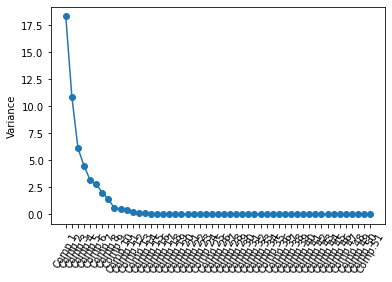

In [41]:
def screeplot(pca, standardised_values):
    y = np.std(pca.transform(standardised_values), axis=0)**2
    x = np.arange(len(y)) + 1
    plt.plot(x, y, "o-")
    plt.xticks(x, ["Comp."+str(i) for i in x], rotation=60)
    plt.ylabel("Variance")
    plt.show()

screeplot(pca, standardisedX)

In [42]:
summary.sdev**2

,Standard deviation
PC1,1.829874e+01
PC2,1.087112e+01
PC3,6.106029e+00
PC4,4.477968e+00
PC5,3.148969e+00
...,...
PC47,5.326731e-31
PC48,1.455760e-31
PC49,4.450203e-31
PC50,3.528664e-31


In [43]:
pca.components_[0]

array([ 0.22695016,  0.22584004,  0.11577526,  0.22584077,  0.06879982,
        0.06484942, -0.09657245, -0.00776955,  0.0062401 , -0.01835881,
       -0.0225005 ,  0.02697008, -0.00531762, -0.00296875,  0.1618643 ,
       -0.09540577, -0.04527832,  0.13027804,  0.16327026, -0.08504846,
        0.04260088,  0.22092308,  0.10361215,  0.22394011, -0.09604933,
        0.10712917, -0.02211069,  0.22362472,  0.06132734, -0.00373284,
       -0.02007275,  0.07339314,  0.22491972,  0.22438106,  0.05285247,
        0.22339148,  0.2252483 ,  0.00366873,  0.02829858,  0.02086801,
       -0.00687908,  0.1895812 ,  0.11779571,  0.19517433,  0.22340726,
        0.22660962, -0.0910512 ,  0.2155591 ,  0.22367015,  0.17555377,
       -0.04670859])

In [44]:
np.sum(pca.components_[0]**2)

0.9999999999999997

In [45]:
def calcpc(variables, loadings):
    # find the number of samples in the data set and the number of variables
    numsamples, numvariables = variables.shape
    # make a vector to store the component
    pc = np.zeros(numsamples)
    # calculate the value of the component for each sample
    for i in range(numsamples):
        valuei = 0
        for j in range(numvariables):
            valueij = variables.iloc[i, j]
            loadingj = loadings[j]
            valuei = valuei + (valueij * loadingj)
        pc[i] = valuei
    return pc

In [46]:
calcpc(standardisedX, pca.components_[0])

array([-3.32554645,  0.46255696, -4.91682923, -4.91682923, -4.91682923,
       -4.91682923, -4.91682923, -4.91682923, 10.41722394,  3.03790947,
       -1.76759541, -1.05023596, -3.96163002, -3.96163002, -3.12443783,
       -3.12443783,  0.50073259,  0.50073259, -5.91930604,  1.65740449,
        1.65740449,  1.65740449, -2.18327715, -1.51348014, 17.3345275 ,
       17.3345275 , -1.48700471,  0.76256602,  0.76256602,  0.76256602,
        0.76256602,  0.76256602,  0.76256602,  0.76256602,  0.76256602,
        0.76256602,  0.76256602,  0.76256602,  0.76256602,  0.76256602,
        0.76256602,  0.76256602,  0.76256602,  0.76256602,  0.76256602,
        0.76256602,  0.76256602,  0.76256602,  0.76256602,  0.76256602,
        0.76256602,  0.76256602,  0.76256602,  0.76256602,  0.76256602,
       -5.33649007, -5.33649007, -5.33649007, -3.32554645,  0.46255696,
       -4.91682923, -4.91682923, -4.91682923, -4.91682923, -4.91682923,
       -4.91682923, 10.41722394,  3.03790947, -1.76759541, -1.05

In [47]:
pca.transform(standardisedX)[:, 0]

array([-3.32554645,  0.46255696, -4.91682923, -4.91682923, -4.91682923,
       -4.91682923, -4.91682923, -4.91682923, 10.41722394,  3.03790947,
       -1.76759541, -1.05023596, -3.96163002, -3.96163002, -3.12443783,
       -3.12443783,  0.50073259,  0.50073259, -5.91930604,  1.65740449,
        1.65740449,  1.65740449, -2.18327715, -1.51348014, 17.3345275 ,
       17.3345275 , -1.48700471,  0.76256602,  0.76256602,  0.76256602,
        0.76256602,  0.76256602,  0.76256602,  0.76256602,  0.76256602,
        0.76256602,  0.76256602,  0.76256602,  0.76256602,  0.76256602,
        0.76256602,  0.76256602,  0.76256602,  0.76256602,  0.76256602,
        0.76256602,  0.76256602,  0.76256602,  0.76256602,  0.76256602,
        0.76256602,  0.76256602,  0.76256602,  0.76256602,  0.76256602,
       -5.33649007, -5.33649007, -5.33649007, -3.32554645,  0.46255696,
       -4.91682923, -4.91682923, -4.91682923, -4.91682923, -4.91682923,
       -4.91682923, 10.41722394,  3.03790947, -1.76759541, -1.05

# The Second principle component:

In [48]:
pca.components_[1]

array([-0.04456093, -0.04742889,  0.17048023, -0.04741871, -0.02080119,
       -0.09572579, -0.02933548, -0.1649711 , -0.07368618, -0.18388823,
        0.05419159,  0.26342931,  0.20918925,  0.24392611,  0.04760343,
       -0.07876379, -0.10801657,  0.21004555,  0.16227078,  0.17054494,
        0.21066573, -0.01937083,  0.137391  , -0.04780695, -0.18177258,
        0.22792907,  0.28552491, -0.04387713,  0.03762502,  0.22797615,
        0.25440369, -0.18951097, -0.0249281 , -0.0522906 ,  0.11903125,
       -0.06169258, -0.04768032, -0.19595561,  0.07297583,  0.23256974,
        0.18003836, -0.01870354,  0.15643139, -0.0859463 , -0.05676195,
       -0.03083266,  0.10514959, -0.00875534, -0.00980102, -0.02154476,
       -0.04452958])

In [49]:
np.sum(pca.components_[1]**2)

1.0000000000000016

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y, data. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


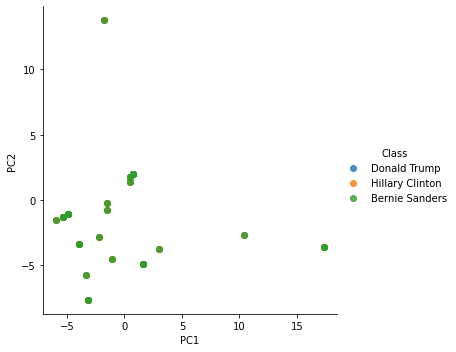

In [50]:
def pca_scatter(pca, standardised_values, classifs):
    foo = pca.transform(standardised_values)
    bar = pd.DataFrame(list(zip(foo[:, 0], foo[:, 1], classifs)), columns=["PC1", "PC2", "Class"])
    sns.lmplot("PC1", "PC2", bar, hue="Class", fit_reg=False)

pca_scatter(pca, standardisedX, y)

In [51]:
printMeanAndSdByGroup(standardisedX, y);

## Means:


,PST045214,PST040210,PST120214,POP010210,AGE135214,AGE295214,AGE775214,SEX255214,RHI125214,RHI225214,RHI325214,RHI425214,RHI525214,RHI625214,RHI725214,RHI825214,POP715213,POP645213,POP815213,EDU635213,EDU685213,VET605213,LFE305213,HSG010214,HSG445213,HSG096213,HSG495213,HSD410213,HSD310213,INC910213,INC110213,PVY020213,BZA010213,BZA110213,BZA115213,NES010213,SBO001207,SBO315207,SBO115207,SBO215207,SBO515207,SBO415207,SBO015207,MAN450207,WTN220207,RTN130207,RTN131207,AFN120207,BPS030214,LND110210,POP060210
candidate,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Bernie Sanders,0.001474,0.001447,0.005056,0.001447,-0.000527,-0.002569,-0.003237,-0.004391,0.001701,-0.005846,0.002691,0.004510,0.000756,0.002800,-0.000383,0.001914,-0.002944,0.005851,0.003692,0.005514,0.008353,0.003034,0.006729,0.001501,-0.005710,0.005552,0.006656,0.001842,-0.003587,0.008063,0.006401,-0.003232,0.002439,0.001025,0.004601,-0.000049,0.000964,-0.006910,0.003346,0.002153,-0.000836,-0.001939,0.005841,0.000004,0.000436,0.002157,0.000701,0.000555,0.001869,0.000266,-0.003772
Donald Trump,-0.003050,-0.002994,-0.010461,-0.002995,0.001090,0.005315,0.006697,0.009086,-0.003519,0.012095,-0.005569,-0.009331,-0.001565,-0.005793,0.000793,-0.003960,0.006092,-0.012106,-0.007638,-0.011409,-0.017281,-0.006278,-0.013923,-0.003105,0.011814,-0.011486,-0.013772,-0.003812,0.007421,-0.016681,-0.013244,0.006686,-0.005046,-0.002121,-0.009520,0.000101,-0.001994,0.014297,-0.006922,-0.004455,0.001730,0.004011,-0.012085,-0.000008,-0.000901,-0.004463,-0.001450,-0.001147,-0.003867,-0.000551,0.007803
Hillary Clinton,0.001474,0.001447,0.005056,0.001447,-0.000527,-0.002569,-0.003237,-0.004391,0.001701,-0.005846,0.002691,0.004510,0.000756,0.002800,-0.000383,0.001914,-0.002944,0.005851,0.003692,0.005514,0.008353,0.003034,0.006729,0.001501,-0.005710,0.005552,0.006656,0.001842,-0.003587,0.008063,0.006401,-0.003232,0.002439,0.001025,0.004601,-0.000049,0.000964,-0.006910,0.003346,0.002153,-0.000836,-0.001939,0.005841,0.000004,0.000436,0.002157,0.000701,0.000555,0.001869,0.000266,-0.003772



## Standard deviations:


,PST045214,PST040210,PST120214,POP010210,AGE135214,AGE295214,AGE775214,SEX255214,RHI125214,RHI225214,RHI325214,RHI425214,RHI525214,RHI625214,RHI725214,RHI825214,POP715213,POP645213,POP815213,EDU635213,EDU685213,VET605213,LFE305213,HSG010214,HSG445213,HSG096213,HSG495213,HSD410213,HSD310213,INC910213,INC110213,PVY020213,BZA010213,BZA110213,BZA115213,NES010213,SBO001207,SBO315207,SBO115207,SBO215207,SBO515207,SBO415207,SBO015207,MAN450207,WTN220207,RTN130207,RTN131207,AFN120207,BPS030214,LND110210,POP060210
candidate,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Bernie Sanders,0.994526,0.994523,0.995572,0.994523,0.994441,0.994724,0.994898,0.995292,0.994558,0.995957,0.994753,0.995339,0.994455,0.99478,0.994435,0.994593,0.994817,0.99596,0.995039,0.995789,0.997546,0.994841,0.996453,0.994530,0.995887,0.995807,0.996410,0.994581,0.995004,0.997334,0.996261,0.994896,0.994695,0.994476,0.995376,0.994429,0.994470,0.996563,0.994930,0.994636,0.994460,0.994597,0.995954,0.994429,0.994437,0.994637,0.994451,0.994443,0.994585,0.994432,0.995065
Donald Trump,1.011224,1.011232,1.009019,1.011232,1.011403,1.010807,1.010442,1.009611,1.011156,1.008206,1.010747,1.009512,1.011375,1.01069,1.011415,1.011084,1.010612,1.00820,1.010145,1.008561,1.004838,1.010562,1.007156,1.011217,1.008354,1.008522,1.007248,1.011109,1.010217,1.005289,1.007563,1.010445,1.010869,1.011330,1.009433,1.011429,1.011341,1.006922,1.010374,1.010992,1.011363,1.011075,1.008211,1.011429,1.011411,1.010991,1.011383,1.011400,1.011100,1.011422,1.010089
Hillary Clinton,0.994526,0.994523,0.995572,0.994523,0.994441,0.994724,0.994898,0.995292,0.994558,0.995957,0.994753,0.995339,0.994455,0.99478,0.994435,0.994593,0.994817,0.99596,0.995039,0.995789,0.997546,0.994841,0.996453,0.994530,0.995887,0.995807,0.996410,0.994581,0.995004,0.997334,0.996261,0.994896,0.994695,0.994476,0.995376,0.994429,0.994470,0.996563,0.994930,0.994636,0.994460,0.994597,0.995954,0.994429,0.994437,0.994637,0.994451,0.994443,0.994585,0.994432,0.995065



## Sample sizes:


,0
candidate,
Bernie Sanders,60
Donald Trump,58
Hillary Clinton,60
